After DigitalSreeni's U-net tutorial: https://youtu.be/azM57JuQpQI
Training data set can be found here : https://www.kaggle.com/c/data-science-bowl-2018/data
Using TensorFlow Keras

In [1]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
# Input images size
IMG_WIDTH = 375
IMG_HEIGHT = 250
IMG_CHANNELS = 3

# Input paths
PARENT_DIR = './drone_dataset_resized/'
ORIGINAL_PATH = 'original_images/'
SEGMENTED_PATH = 'label_images_semantic/'

#consistent randomness and good-luck charm
seed = 42
np.random.seed = seed

Importing the data

In [3]:
train_ids = os.listdir(PARENT_DIR + ORIGINAL_PATH)

Defining the train and control set +  Pre-processing the train data to fit into our U-net

In [4]:
X_train = np.zeros((len(train_ids),IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids),IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    #Actual train image
    img = imread(PARENT_DIR + ORIGINAL_PATH + id_)[:, :, :IMG_CHANNELS]
    X_train[n] = img
    mask = imread(PARENT_DIR + SEGMENTED_PATH + id_.split(".")[0] + '.png')[:, :, :IMG_CHANNELS]
    Y_train[n] = mask

100%|██████████| 400/400 [00:01<00:00, 226.00it/s]


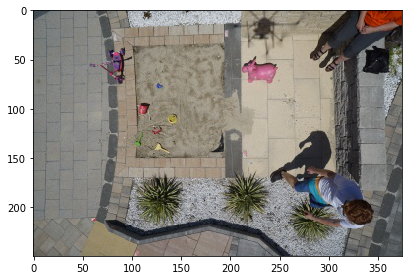

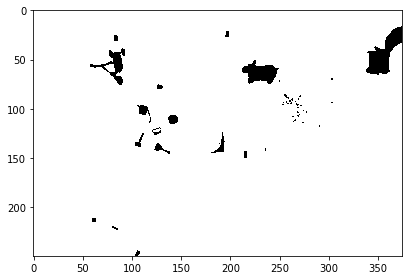

In [5]:
image_we = random.randint(0, len(train_ids))
#original
imshow(X_train[image_we])
plt.show()
#control
imshow(np.squeeze(Y_train[image_we]))
plt.show()


Model creation after U-net diagram (I need to find out how to import an image here :) )

In [6]:
# Input layer
inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS))

In [7]:
# Converts pixel value to float, and normalizes it
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

First convolutional layers, size = 16 of  (3x3) convolutional kernels 
                                          -initializing them with 'he_normal' kernel_initializer
                                          
After each convolution we drop out some of output's data to reduce/prevent overfitting
MaxPooling is user to 'contract' the input reducing its size and combating overfitting

In [8]:
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

In [9]:
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

In [10]:
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

In [11]:
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

In [12]:
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c5)

From this point we should start the expansion path of the processed data
    Before further processing of the expanded data, we concatenate its with the previous layer 

In [13]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2, 2), padding='same')(c5)
#redimensionare pentru concatenare
u6 = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,0)))(u6) #((top_pad, bottom_pad), (left_pad, right_pad))
u6 = tf.keras.layers.concatenate([u6, c4])

c6 = tf.keras.layers.Conv2D(128, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c6)


In [14]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.ZeroPadding2D(padding=((0,0),(0,1)))(u7)
u7 = tf.keras.layers.concatenate([u7, c3])

c7 = tf.keras.layers.Conv2D(64, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c7)


In [15]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(u8)
u8 = tf.keras.layers.concatenate([u8, c2])

c8 = tf.keras.layers.Conv2D(32, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c8)


In [16]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.ZeroPadding2D(padding=((0,0),(0,1)))(u9)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)

c9 = tf.keras.layers.Conv2D(16, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3),activation = 'relu', kernel_initializer='he_normal', padding = 'same')(c9)


In [23]:
outputs = tf.keras.layers.Conv2D(IMG_CHANNELS, (1, 1), activation='sigmoid')(c9)
print(outputs.shape)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

(None, 250, 375, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 375, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 250, 375, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 250, 375, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 250, 375, 16) 2320        dropout[0][0]                    
________________________________________________________________________

Checkpoints, just in case

In [24]:
#Model checkoints
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose = 1, save_best_only = True )

We send callbacks for aditional control:
    EarlyStopping if the monitor does not improve over "patience" epochs
    TensorBoard is a visualization tool saved in log_dir inside parent directory

In [25]:
#Callbacks
callbacks =[
   tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
   tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [26]:
results = model.fit(X_train,Y_train,validation_split=0.3, batch_size = 16, epochs = 15, callbacks=callbacks)

Epoch 1/15
18/18 [==============================] - 10s 537ms/step - loss: -30552486.0000 - accuracy: 0.5262 - val_loss: -1078144256.0000 - val_accuracy: 0.9986
Epoch 2/15
18/18 [==============================] - 9s 513ms/step - loss: -21067364342693888.0000 - accuracy: 0.9945 - val_loss: -545542347891408896.0000 - val_accuracy: 1.0000
Epoch 3/15
18/18 [==============================] - 9s 518ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/15
18/18 [==============================] - 9s 519ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000


Testing the model

In [27]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.1)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.1):], verbose=1)
#preds_test = model.predict(X_test, verbose = 1)

#Binarizationing the results
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

12/12 [==============================] - 3s 270ms/step


<ipython-input-27-20590750ca48>:8: RuntimeWarning: invalid value encountered in greater
  preds_train_t = (preds_train > 0.5).astype(np.uint8)
<ipython-input-27-20590750ca48>:9: RuntimeWarning: invalid value encountered in greater
  preds_val_t = (preds_val > 0.5).astype(np.uint8)


Printing some results

In [ ]:
#random training sample
i = random.randint(0, len(preds_train_t))
imshow(X_train[i])
plt.show()
imshow(np.squeeze(Y_train[i]))
plt.show()
imshow(np.squeeze(preds_train_t[i]))
plt.show()

#random validation sample
# i = random.randint(0, len(preds_val_t))
# imshow(X_train[int(X_train.shape[0]*0.9):][i])
# plt.show()
# imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][i]))
# plt.show()
# imshow(np.squeeze( preds_val_t[i]))
# plt.show()
